# Hyperparameter Optimization for 2-Arm ANCOVA NPE Model

This notebook performs **Bayesian Optimization** (Optuna) to find optimal neural network architecture for the 2-arm ANCOVA amortized posterior estimation model.

## Objectives
1. **Minimize calibration error** (mean absolute coverage error)
2. **Minimize parameter count** (model size)

This is a multi-objective optimization with Pareto-optimal solutions.

In [1]:
import os

if not os.environ.get("KERAS_BACKEND"):
    os.environ["KERAS_BACKEND"] = "torch"
    
from pathlib import Path

import numpy as np
np.set_printoptions(suppress=True)
RNG = np.random.default_rng(2025)

import keras
import bayesflow as bf
import matplotlib.pyplot as plt

# Import ANCOVA-specific functions
from rctbp_bf_training.models.ancova.model import (
    ANCOVAConfig,
    create_ancova_adapter,
    create_simulator,
    create_validation_grid,
    get_model_metadata,
    save_model_with_metadata,
    create_ancova_objective,
    create_ancova_training_functions,
)

# Import infrastructure (for final model saving)
from rctbp_bf_training.core.infrastructure import params_dict_to_workflow_config

# Import Bayesian optimization infrastructure
from rctbp_bf_training.core import optimization
from rctbp_bf_training.core.optimization import (
    create_study,
    HyperparameterSpace,
    get_param_count,
    plot_optimization_results,
    summarize_best_trials,
    train_until_threshold,
    QualityThresholds,
)

# Create default configuration
config = ANCOVAConfig()
print(f"Config loaded: ancova_cont_2arms")
print(f"\nNetwork configs:")
print(f"  Summary network: {config.workflow.summary_network}")
print(f"  Inference network: {config.workflow.inference_network}")
print(f"\nOptuna available: {optimization.OPTUNA_AVAILABLE}")

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


Config loaded: ancova_cont_2arms

Network configs:
  Summary network: SummaryNetworkConfig(summary_dim=10, depth=3, width=64, dropout=0.05, network_type='DeepSet')
  Inference network: InferenceNetworkConfig(depth=7, hidden_sizes=(128, 128), dropout=0.2, network_type='CouplingFlow')

Optuna available: True


In [2]:
# Create simulator and adapter (prerequisites for optimization)
simulator = create_simulator(config, RNG)
adapter = create_ancova_adapter()

print("Setup complete:")
print(f"  Simulator ready with {len(simulator.sample(1).keys())} output keys")
print(f"  Adapter configured for ANCOVA model")

Setup complete:
  Simulator ready with 9 output keys
  Adapter configured for ANCOVA model


## Search Space and Optimization Grid

Define the hyperparameter search space and a reduced validation grid for faster optimization.

In [3]:
# Define search space (customize ranges as needed)
search_space = HyperparameterSpace(
    # DeepSet
    summary_dim=(4, 16),
    deepset_width=(32, 128),
    deepset_depth=(1, 4),
    deepset_dropout=(0.05, 0.5),
    
    # CouplingFlow  
    flow_depth=(2, 8),
    flow_hidden=(32, 128),
    flow_dropout=(0.05, 0.5),
    
    # Training
    initial_lr=(1e-5, 5e-3),
    batch_size=(128, 832),
    
    # Fixed (not optimized)
    decay_rate=0.85,
    patience=10,
    window=20,
)

# Use factory function for validation grid
opt_conditions = create_validation_grid(extended=True)

print(f"Search space defined with {len(search_space.__dataclass_fields__)} parameters")
print(f"Optimization validation grid: {len(opt_conditions)} conditions")

Search space defined with 12 parameters
Optimization validation grid: 144 conditions


In [4]:
# Create objective function using factory
objective = create_ancova_objective(
    config=config,
    simulator=simulator,
    adapter=adapter,
    search_space=search_space,
    validation_conditions=opt_conditions,
    n_sims=500,
    n_post_draws=500,
    rng=RNG,
)

print("Objective function created via factory")
print(f"  Validation grid: {len(opt_conditions)} conditions")

Objective function created via factory
  Validation grid: 144 conditions


## Create Study

Create the multi-objective Optuna study. Results are saved to SQLite for resumption.

In [5]:
# Create multi-objective study
study = create_study(
    study_name="ancova_cont_2arms",
    directions=["minimize", "minimize"],  # [calibration_error, param_count]
    storage="sqlite:///optuna_ancova_cont_2arms.db",  # Persistent storage for resumption
    load_if_exists=True,
)

print(f"Study created: {study.study_name}")
print(f"Existing trials: {len(study.trials)}")
print(f"Directions: {study.directions}")

[I 2026-01-02 13:01:52,712] A new study created in RDB with name: ancova_cont_2arms


Study created: ancova_cont_2arms
Existing trials: 0
Directions: [<StudyDirection.MINIMIZE: 1>, <StudyDirection.MINIMIZE: 1>]


In [ ]:
# To monitor optimization in real-time, launch the Optuna Dashboard from a separate terminal:
#
#   python -m rctbp_bf_training.core.optimization --dashboard sqlite:///optuna_ancova_cont_2arms.db
#
# Or from Python:
#   from rctbp_bf_training.core.optimization import launch_dashboard
#   launch_dashboard("sqlite:///optuna_ancova_cont_2arms.db")
#
# Requires: pip install optuna-dashboard

print("Dashboard command:")
print("  python -m rctbp_bf_training.core.optimization --dashboard sqlite:///optuna_ancova_cont_2arms.db")

## Run Optimization

Run the multi-objective optimization study.

In [6]:
# Run optimization (adjust n_trials based on compute budget)
# Each trial takes ~5-10 minutes depending on architecture
N_TRIALS = 100  # Adjust as needed

study.optimize(
    objective,
    n_trials=N_TRIALS,
    show_progress_bar=True,
    gc_after_trial=True,
)

print(f"\nOptimization complete!")
print(f"Total trials: {len(study.trials)}")
print(f"Pareto-optimal trials: {len(study.best_trials)}")

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - loss: 5.8415 - val_loss: 0.1016 - moving_avg_val_loss: 0.1016
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - loss: 2.9167 - val_loss: -0.1039 - moving_avg_val_loss: -0.0011
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - loss: 2.3457 - val_loss: 1.1045 - moving_avg_val_loss: 0.3674
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 446s 9s/step - loss: 106.0135 - val_loss: 1.8554 - moving_avg_val_loss: 0.7394
Epoch 5/200
22/50 ━━━━━━━━━━━━━━━━━━━━ 6:20 14s/step - loss: 1.2714Trial 0 FAILED: Exception encountered when calling Activation.call().

CUDA out of memory. Tried to allocate 310.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 15.81 GiB is allocated by PyTorch, and 4.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Manageme

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 276s 6s/step - loss: 0.6727 - val_loss: -0.3148 - moving_avg_val_loss: -0.3148
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 239s 5s/step - loss: -0.9910 - val_loss: -1.9233 - moving_avg_val_loss: -1.1191
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - loss: 0.6344 - val_loss: -2.1790 - moving_avg_val_loss: -1.4724
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - loss: -1.8906 - val_loss: -2.1149 - moving_avg_val_loss: -1.6330
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - loss: -1.7700 - val_loss: -2.2161 - moving_avg_val_loss: -1.7496
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - loss: 3.3320 - val_loss: -1.8515 - moving_avg_val_loss: -1.7666
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - loss: -1.5312 - val_loss: -1.9009 - moving_avg_val_loss: -1.7858
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 235s 5s/step - loss: -1.1057 - val_loss: -1.8852 - moving_avg_val_loss: -1.7982
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 532ms/step - loss: 1.9177 - val_loss: 0.1773 - moving_avg_val_loss: 0.1773
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 762ms/step - loss: 1.8611 - val_loss: 0.1919 - moving_avg_val_loss: 0.1846
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 779ms/step - loss: 17.2348 - val_loss: 0.9759 - moving_avg_val_loss: 0.4484
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 735ms/step - loss: 3.9330 - val_loss: 2.0894 - moving_avg_val_loss: 0.8586
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 887ms/step - loss: 1.9384 - val_loss: -0.3371 - moving_avg_val_loss: 0.6195
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 855ms/step - loss: -0.0686 - val_loss: -0.6384 - moving_avg_val_loss: 0.4098
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 994ms/step - loss: 7.3745 - val_loss: 1.1931 - moving_avg_val_loss: 0.5217
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 16.4419 - val_loss: 1.5113 - moving_avg_val_loss: 0.6454
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - l

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 2.3318 - val_loss: 0.6584 - moving_avg_val_loss: 0.6584
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - loss: 100.9352 - val_loss: -0.9273 - moving_avg_val_loss: -0.1344
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - loss: 1.6601 - val_loss: -0.3858 - moving_avg_val_loss: -0.2182
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - loss: 0.4569 - val_loss: -0.3052 - moving_avg_val_loss: -0.2400
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - loss: 6.8418 - val_loss: 1.8689 - moving_avg_val_loss: 0.1818
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - loss: 2.9228 - val_loss: 0.9718 - moving_avg_val_loss: 0.3135
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - loss: 1.9920 - val_loss: 0.6120 - moving_avg_val_loss: 0.3561
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - loss: 1.2636 - val_loss: 1.3870 - moving_avg_val_loss: 0.4850
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - loss: 1.4290

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - loss: 1.7557 - val_loss: 17238.4336 - moving_avg_val_loss: 17238.4336
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - loss: 8.3067 - val_loss: 155.5446 - moving_avg_val_loss: 8696.9891
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - loss: 1.1380 - val_loss: 1481.4985 - moving_avg_val_loss: 6291.8256
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 294ms/step - loss: 5.2996 - val_loss: 302.1990 - moving_avg_val_loss: 4794.4189
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - loss: 22.0331 - val_loss: 2.3267 - moving_avg_val_loss: 3836.0005
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - loss: 2.1947 - val_loss: 3.0782 - moving_avg_val_loss: 3197.1801
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - loss: -0.8024 - val_loss: 156.9808 - moving_avg_val_loss: 2762.8659
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - loss: 0.4088 - val_loss: 56.0079 - moving_avg_val_loss: 2424.5087
Epoch 9/200
50/

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - loss: 5.7086 - val_loss: 0.6251 - moving_avg_val_loss: 0.6251
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 334s 6s/step - loss: 3.0710 - val_loss: 0.0695 - moving_avg_val_loss: 0.3473
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - loss: 4.1664 - val_loss: 0.4602 - moving_avg_val_loss: 0.3849
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - loss: 1.1717 - val_loss: 0.1410 - moving_avg_val_loss: 0.3240
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step - loss: 0.2760 - val_loss: -1.3870 - moving_avg_val_loss: -0.0182
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - loss: 1.9098 - val_loss: -1.6195 - moving_avg_val_loss: -0.2851
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - loss: 125.5736 - val_loss: 0.1601 - moving_avg_val_loss: -0.2215
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 284s 6s/step - loss: 7.0962 - val_loss: -0.1070 - moving_avg_val_loss: -0.2072
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 294s 6s/step - loss: 1.7

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - loss: 1.6036 - val_loss: 0.6400 - moving_avg_val_loss: 0.6400
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - loss: 1.1886 - val_loss: -0.4257 - moving_avg_val_loss: 0.1071
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - loss: -0.4379 - val_loss: -1.1416 - moving_avg_val_loss: -0.3091
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - loss: -0.7960 - val_loss: -1.4867 - moving_avg_val_loss: -0.6035
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - loss: -1.2723 - val_loss: -1.7701 - moving_avg_val_loss: -0.8368
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - loss: -1.3024 - val_loss: -1.9495 - moving_avg_val_loss: -1.0223
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - loss: -1.7034 - val_loss: -2.1063 - moving_avg_val_loss: -1.1771
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - loss: -1.4449 - val_loss: -2.2167 - moving_avg_val_loss: -1.3071
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step -

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - loss: 1.4287 - val_loss: 1.0384 - moving_avg_val_loss: 1.0384
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 322ms/step - loss: 3.6784 - val_loss: -0.2941 - moving_avg_val_loss: 0.3721
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - loss: 22.8694 - val_loss: 0.1771 - moving_avg_val_loss: 0.3071
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - loss: 3.2759 - val_loss: -0.4704 - moving_avg_val_loss: 0.1128
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 331ms/step - loss: 1.3995 - val_loss: 0.4319 - moving_avg_val_loss: 0.1766
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 335ms/step - loss: 1.1128 - val_loss: 0.7634 - moving_avg_val_loss: 0.2744
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 328ms/step - loss: 0.6972 - val_loss: -0.5520 - moving_avg_val_loss: 0.1563
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - loss: 5.8836 - val_loss: -1.3054 - moving_avg_val_loss: -0.0264
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/s

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - loss: 1.6214 - val_loss: 0.9202 - moving_avg_val_loss: 0.9202
Epoch 2/200
25/50 ━━━━━━━━━━━━━━━━━━━━ 5:07 12s/step - loss: 1.2637Trial 8 FAILED: Exception encountered when calling Dense.call().

CUDA out of memory. Tried to allocate 350.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 18.91 GiB is allocated by PyTorch, and 1.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Arguments received by Dense.call():
  • inputs=torch.Tensor(shape=torch.Size([896, 912, 112]), dtype=float32)
  • training=True
[I 2026-01-03 02:09:42,729] Trial 8 finished with values: [1.0, 1000000000.0] and parameters: {'summary_dim': 4, 'deepset_width': 112, 'deepset_depth': 

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 4.0486 - val_loss: -1.0530 - moving_avg_val_loss: -1.0530
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 9.7910 - val_loss: -1.1486 - moving_avg_val_loss: -1.1008
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 1.4184 - val_loss: -0.8503 - moving_avg_val_loss: -1.0173
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 2.7003 - val_loss: 0.6295 - moving_avg_val_loss: -0.6056
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.6428 - val_loss: -0.4845 - moving_avg_val_loss: -0.5814
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 1.6091 - val_loss: 1.0780 - moving_avg_val_loss: -0.3048
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - loss: 4.4064 - val_loss: 1.2857 - moving_avg_val_loss: -0.0776
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 3.0085 - val_loss: -0.2134 - moving_avg_val_loss: -0.0945
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - loss: 0.6330 

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step - loss: 1.7264 - val_loss: 0.9833 - moving_avg_val_loss: 0.9833
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - loss: 0.2292 - val_loss: -0.7016 - moving_avg_val_loss: 0.1408
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - loss: 24.4675 - val_loss: -0.2235 - moving_avg_val_loss: 0.0194
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 392ms/step - loss: -0.9275 - val_loss: -2.5858 - moving_avg_val_loss: -0.6319
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 384ms/step - loss: 4.3246 - val_loss: -1.9640 - moving_avg_val_loss: -0.8983
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - loss: -1.6803 - val_loss: -2.6140 - moving_avg_val_loss: -1.1843
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - loss: 396.2327 - val_loss: -0.1200 - moving_avg_val_loss: -1.0322
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - loss: 0.3297 - val_loss: 0.8208 - moving_avg_val_loss: -0.8006
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 2.3306 - val_loss: 0.5000 - moving_avg_val_loss: 0.5000
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - loss: 7.8712 - val_loss: 0.2651 - moving_avg_val_loss: 0.3826
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 924ms/step - loss: 0.2452 - val_loss: -0.2083 - moving_avg_val_loss: 0.1856
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - loss: -0.7660 - val_loss: -2.8136 - moving_avg_val_loss: -0.5642
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: -1.9571 - val_loss: -3.1491 - moving_avg_val_loss: -1.0812
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - loss: 72.3874 - val_loss: -3.2567 - moving_avg_val_loss: -1.4438
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: -1.9097 - val_loss: -2.8263 - moving_avg_val_loss: -1.6413
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: -2.1352 - val_loss: -2.9559 - moving_avg_val_loss: -1.8056
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - loss

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 750ms/step - loss: 2.0080 - val_loss: 6.2813 - moving_avg_val_loss: 6.2813
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 775ms/step - loss: 4.0341 - val_loss: 1.7682 - moving_avg_val_loss: 4.0247
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 753ms/step - loss: 6.1427 - val_loss: 4.4910 - moving_avg_val_loss: 4.1802
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 929ms/step - loss: 2.7009 - val_loss: 0.5902 - moving_avg_val_loss: 3.2827
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 755ms/step - loss: 3.9620 - val_loss: 1.7392 - moving_avg_val_loss: 2.9740
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 819ms/step - loss: 0.5490 - val_loss: -0.9443 - moving_avg_val_loss: 2.3209
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 804ms/step - loss: -0.3203 - val_loss: -0.4502 - moving_avg_val_loss: 1.9251
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 771ms/step - loss: -1.0345 - val_loss: -2.5771 - moving_avg_val_loss: 1.3623
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 764ms/st

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 367s 7s/step - loss: 1.3978 - val_loss: -0.5244 - moving_avg_val_loss: -0.5244
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - loss: 4.0289 - val_loss: -0.3129 - moving_avg_val_loss: -0.4187
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 322s 6s/step - loss: -0.0085 - val_loss: -0.2343 - moving_avg_val_loss: -0.3572
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - loss: 1.9252 - val_loss: 0.3070 - moving_avg_val_loss: -0.1912
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - loss: 0.6910 - val_loss: 0.2395 - moving_avg_val_loss: -0.1050
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - loss: 7.0599 - val_loss: 0.5558 - moving_avg_val_loss: 0.0051
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 229s 5s/step - loss: 0.6985 - val_loss: 0.6386 - moving_avg_val_loss: 0.0956
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - loss: 3.6957 - val_loss: 1.0705 - moving_avg_val_loss: 0.2175
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - loss: 4.1

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - loss: 1.7899 - val_loss: 0.1580 - moving_avg_val_loss: 0.1580
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - loss: 0.7207 - val_loss: -1.9301 - moving_avg_val_loss: -0.8860
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 287s 6s/step - loss: -0.5321 - val_loss: -2.5717 - moving_avg_val_loss: -1.4479
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 336s 7s/step - loss: -1.5350 - val_loss: -3.1223 - moving_avg_val_loss: -1.8665
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 271s 6s/step - loss: -2.6062 - val_loss: -3.2031 - moving_avg_val_loss: -2.1338
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 351s 7s/step - loss: -2.7939 - val_loss: -2.5605 - moving_avg_val_loss: -2.2049
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - loss: -2.4741 - val_loss: -3.2977 - moving_avg_val_loss: -2.3611
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - loss: -0.1679 - val_loss: -3.8995 - moving_avg_val_loss: -2.5534
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 324s 6s/step 

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 4.0393 - val_loss: 0.6030 - moving_avg_val_loss: 0.6030
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - loss: 1.5217 - val_loss: 0.7983 - moving_avg_val_loss: 0.7007
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - loss: 2.3954 - val_loss: 1.0021 - moving_avg_val_loss: 0.8011
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - loss: 0.6686 - val_loss: -0.1558 - moving_avg_val_loss: 0.5619
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - loss: 2.2511 - val_loss: -0.7884 - moving_avg_val_loss: 0.2918
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - loss: -1.1081 - val_loss: -0.9783 - moving_avg_val_loss: 0.0802
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - loss: -1.7731 - val_loss: -0.8865 - moving_avg_val_loss: -0.0579
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: -2.0191 - val_loss: 0.1183 - moving_avg_val_loss: -0.0359
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: -2.13

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - loss: 1.6928 - val_loss: 0.9068 - moving_avg_val_loss: 0.9068
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - loss: 0.8857 - val_loss: 0.8395 - moving_avg_val_loss: 0.8731
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - loss: 0.7155 - val_loss: 0.2916 - moving_avg_val_loss: 0.6793
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - loss: 11.6166 - val_loss: -0.0550 - moving_avg_val_loss: 0.4957
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - loss: 0.0154 - val_loss: -0.1384 - moving_avg_val_loss: 0.3689
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - loss: -0.1540 - val_loss: -0.3648 - moving_avg_val_loss: 0.2466
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - loss: -0.2983 - val_loss: -0.5931 - moving_avg_val_loss: 0.1267
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - loss: -0.5170 - val_loss: -0.8195 - moving_avg_val_loss: 0.0084
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252m

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 2.4112 - val_loss: 0.5300 - moving_avg_val_loss: 0.5300
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - loss: 0.9345 - val_loss: -0.4330 - moving_avg_val_loss: 0.0485
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - loss: 0.8673 - val_loss: -2.5476 - moving_avg_val_loss: -0.8169
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - loss: -0.7463 - val_loss: -3.1145 - moving_avg_val_loss: -1.3913
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - loss: -0.8465 - val_loss: -3.2023 - moving_avg_val_loss: -1.7535
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - loss: -2.3147 - val_loss: -3.4313 - moving_avg_val_loss: -2.0331
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - loss: -2.2505 - val_loss: -2.8865 - moving_avg_val_loss: -2.1550
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - loss: -2.6320 - val_loss: -3.8970 - moving_avg_val_loss: -2.3728
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - l

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - loss: 14.8030 - val_loss: -0.1022 - moving_avg_val_loss: -0.1022
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - loss: 1.3899 - val_loss: -0.5526 - moving_avg_val_loss: -0.3274
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - loss: -0.2822 - val_loss: -0.5587 - moving_avg_val_loss: -0.4045
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - loss: -1.5127 - val_loss: -1.7120 - moving_avg_val_loss: -0.7314
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - loss: -1.6296 - val_loss: -1.6579 - moving_avg_val_loss: -0.9167
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - loss: -1.1384 - val_loss: -2.0247 - moving_avg_val_loss: -1.1014
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - loss: -1.5821 - val_loss: -2.0291 - moving_avg_val_loss: -1.2339
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: -1.8413 - val_loss: -2.3014 - moving_avg_val_loss: -1.3673
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 13.0335 - val_loss: 0.5449 - moving_avg_val_loss: 0.5449
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 1.3099 - val_loss: -1.0219 - moving_avg_val_loss: -0.2385
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: -0.4688 - val_loss: -1.1031 - moving_avg_val_loss: -0.5267
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: -1.1080 - val_loss: -1.8914 - moving_avg_val_loss: -0.8679
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: -1.4307 - val_loss: -2.0858 - moving_avg_val_loss: -1.1115
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - loss: -0.7549 - val_loss: -1.6573 - moving_avg_val_loss: -1.2024
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: -1.5799 - val_loss: -2.0124 - moving_avg_val_loss: -1.3181
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: -1.5443 - val_loss: -2.4487 - moving_avg_val_loss: -1.4595
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 1

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - loss: 10.5820 - val_loss: 1.0064 - moving_avg_val_loss: 1.0064
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 2.2955 - val_loss: 1.0278 - moving_avg_val_loss: 1.0171
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.5346 - val_loss: 0.2417 - moving_avg_val_loss: 0.7586
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 136.0351 - val_loss: -0.5142 - moving_avg_val_loss: 0.4404
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 966ms/step - loss: 4.6970 - val_loss: -0.5822 - moving_avg_val_loss: 0.2359
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 9.3303 - val_loss: -0.5857 - moving_avg_val_loss: 0.0990
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - loss: 21.9098 - val_loss: -0.5542 - moving_avg_val_loss: 0.0056
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 1.2098 - val_loss: -0.5179 - moving_avg_val_loss: -0.0598
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 0.7398 -

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - loss: 11.2658 - val_loss: 0.7282 - moving_avg_val_loss: 0.7282
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - loss: 1.8051 - val_loss: 0.9660 - moving_avg_val_loss: 0.8471
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - loss: 4.9593 - val_loss: 1.0420 - moving_avg_val_loss: 0.9121
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - loss: 3.0080 - val_loss: 0.2981 - moving_avg_val_loss: 0.7586
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - loss: 1.3978 - val_loss: 0.5507 - moving_avg_val_loss: 0.7170
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - loss: 3.8040 - val_loss: 1.3462 - moving_avg_val_loss: 0.8219
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - loss: 0.7553 - val_loss: -0.4266 - moving_avg_val_loss: 0.6435
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - loss: 2.3348 - val_loss: 0.8156 - moving_avg_val_loss: 0.6650
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - loss: 0.3113 - v

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - loss: 1.7868 - val_loss: 0.8862 - moving_avg_val_loss: 0.8862
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - loss: 0.8017 - val_loss: 0.6111 - moving_avg_val_loss: 0.7487
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 436ms/step - loss: 0.4347 - val_loss: -0.0252 - moving_avg_val_loss: 0.4907
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - loss: 1.3631 - val_loss: -0.0455 - moving_avg_val_loss: 0.3567
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 379ms/step - loss: 0.0958 - val_loss: -0.1728 - moving_avg_val_loss: 0.2508
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 701ms/step - loss: -0.1803 - val_loss: -0.3554 - moving_avg_val_loss: 0.1498
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 632ms/step - loss: 40.8076 - val_loss: -0.2585 - moving_avg_val_loss: 0.0914
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 661ms/step - loss: -0.0501 - val_loss: -0.2740 - moving_avg_val_loss: 0.0457
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 809m

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - loss: 3.3355 - val_loss: -0.2301 - moving_avg_val_loss: -0.2301
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - loss: 0.7732 - val_loss: -0.6246 - moving_avg_val_loss: -0.4273
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - loss: -0.6524 - val_loss: -2.4132 - moving_avg_val_loss: -1.0893
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - loss: -1.2916 - val_loss: -2.5706 - moving_avg_val_loss: -1.4596
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - loss: 1.9130 - val_loss: -1.7171 - moving_avg_val_loss: -1.5111
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - loss: 0.1518 - val_loss: -2.1114 - moving_avg_val_loss: -1.6112
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - loss: -1.1278 - val_loss: -1.7012 - moving_avg_val_loss: -1.6240
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - loss: -1.0952 - val_loss: -2.1313 - moving_avg_val_loss: -1.6874
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - loss: 1.8270 - val_loss: 0.9943 - moving_avg_val_loss: 0.9943
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - loss: 1.6423 - val_loss: 0.9535 - moving_avg_val_loss: 0.9739
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - loss: 1.7330 - val_loss: 0.5261 - moving_avg_val_loss: 0.8246
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - loss: -0.0239 - val_loss: -2.1800 - moving_avg_val_loss: 0.0735
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - loss: -2.0777 - val_loss: -0.5607 - moving_avg_val_loss: -0.0534
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - loss: -2.1315 - val_loss: -1.0694 - moving_avg_val_loss: -0.2227
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 306s 6s/step - loss: -2.1914 - val_loss: -1.3234 - moving_avg_val_loss: -0.3799
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 229s 5s/step - loss: 28.3702 - val_loss: -1.5666 - moving_avg_val_loss: -0.5283
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - loss

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - loss: 1.5173 - val_loss: 0.5353 - moving_avg_val_loss: 0.5353
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - loss: 7.5756 - val_loss: 0.9877 - moving_avg_val_loss: 0.7615
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - loss: 2.0447 - val_loss: 1.1273 - moving_avg_val_loss: 0.8834
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 285s 6s/step - loss: 2.2954 - val_loss: 0.9315 - moving_avg_val_loss: 0.8954
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - loss: 2.2252 - val_loss: 1.0963 - moving_avg_val_loss: 0.9356
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - loss: 0.9852 - val_loss: -0.9638 - moving_avg_val_loss: 0.6191
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - loss: -0.4440 - val_loss: -1.6097 - moving_avg_val_loss: 0.3007
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - loss: 0.1802 - val_loss: 1.8698 - moving_avg_val_loss: 0.4968
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 290s 6s/step - loss: -1.1964 -

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - loss: 63.7870 - val_loss: 0.7645 - moving_avg_val_loss: 0.7645
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 399s 8s/step - loss: 15.7313 - val_loss: 1.0166 - moving_avg_val_loss: 0.8906
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 454s 9s/step - loss: 25.9441 - val_loss: 1.2017 - moving_avg_val_loss: 0.9943
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 422s 9s/step - loss: 1.6947 - val_loss: 0.5700 - moving_avg_val_loss: 0.8882
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 373s 8s/step - loss: 2.2159 - val_loss: -0.3544 - moving_avg_val_loss: 0.6397
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 374s 8s/step - loss: 0.4141 - val_loss: -1.7247 - moving_avg_val_loss: 0.2456
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - loss: -0.5732 - val_loss: -1.6747 - moving_avg_val_loss: -0.0287
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 299s 6s/step - loss: -1.0095 - val_loss: -2.9271 - moving_avg_val_loss: -0.3910
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - loss: -

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 901ms/step - loss: 0.6964 - val_loss: 20.2514 - moving_avg_val_loss: 20.2514
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 980ms/step - loss: 17.7728 - val_loss: 26.9580 - moving_avg_val_loss: 23.6047
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 754ms/step - loss: 22.9126 - val_loss: 2.9352 - moving_avg_val_loss: 16.7149
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 958ms/step - loss: -0.0097 - val_loss: 3.2483 - moving_avg_val_loss: 13.3482
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - loss: 18.0183 - val_loss: 0.0026 - moving_avg_val_loss: 10.6791
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: -0.3377 - val_loss: 0.1864 - moving_avg_val_loss: 8.9303
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 829ms/step - loss: -0.4440 - val_loss: 0.1009 - moving_avg_val_loss: 7.6690
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - loss: -0.7253 - val_loss: -0.1148 - moving_avg_val_loss: 6.6960
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 975ms/s

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 637ms/step - loss: 1.2626 - val_loss: 0.7388 - moving_avg_val_loss: 0.7388
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - loss: 2.6969 - val_loss: 0.8553 - moving_avg_val_loss: 0.7970
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 474ms/step - loss: 1.5692 - val_loss: 0.8575 - moving_avg_val_loss: 0.8172
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 444ms/step - loss: 0.7715 - val_loss: 0.7994 - moving_avg_val_loss: 0.8128
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 596ms/step - loss: 2.4819 - val_loss: 0.8664 - moving_avg_val_loss: 0.8235
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 569ms/step - loss: 1.6437 - val_loss: 0.8913 - moving_avg_val_loss: 0.8348
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 506ms/step - loss: 2.0761 - val_loss: 0.9085 - moving_avg_val_loss: 0.8453
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 449ms/step - loss: 0.8001 - val_loss: 0.8963 - moving_avg_val_loss: 0.8517
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 575ms/step - 

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 312ms/step - loss: 6.9538 - val_loss: 0.3435 - moving_avg_val_loss: 0.3435
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - loss: 4.2957 - val_loss: 0.6516 - moving_avg_val_loss: 0.4976
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - loss: 0.2873 - val_loss: 0.3919 - moving_avg_val_loss: 0.4623
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 307ms/step - loss: -0.3962 - val_loss: -0.5122 - moving_avg_val_loss: 0.2187
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 314ms/step - loss: -1.5661 - val_loss: -2.0378 - moving_avg_val_loss: -0.2326
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - loss: -2.1955 - val_loss: -2.4342 - moving_avg_val_loss: -0.5995
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - loss: -2.5710 - val_loss: -2.9725 - moving_avg_val_loss: -0.9385
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 313ms/step - loss: -2.7339 - val_loss: -3.2129 - moving_avg_val_loss: -1.2228
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
14/50 ━━━━━━━━━━━━━━━━━━━━ 5:25 9s/step - loss: 1.5151Trial 30 FAILED: Exception encountered when calling Dropout.call().

CUDA out of memory. Tried to allocate 328.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 19.65 GiB is allocated by PyTorch, and 739.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Arguments received by Dropout.call():
  • inputs=torch.Tensor(shape=torch.Size([768, 996, 112]), dtype=float32)
  • training=True
[I 2026-01-04 23:48:13,726] Trial 30 finished with values: [1.0, 1000000000.0] and parameters: {'summary_dim': 14, 'deepset_width': 112, 'deepset_depth': 4, 'deepset_dropout': 0.4609582486504121, 'flow_depth': 5, 'flow_hidden': 80, 'flow_dropout': 0.409232830535

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - loss: 1.6073 - val_loss: 0.5804 - moving_avg_val_loss: 0.5804
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - loss: -0.3755 - val_loss: -1.2128 - moving_avg_val_loss: -0.3162
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 289s 6s/step - loss: -1.1952 - val_loss: -1.2261 - moving_avg_val_loss: -0.6195
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - loss: -1.6077 - val_loss: -1.7976 - moving_avg_val_loss: -0.9140
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 372s 7s/step - loss: -1.4207 - val_loss: -1.6177 - moving_avg_val_loss: -1.0548
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 436s 8s/step - loss: -1.6488 - val_loss: -1.2368 - moving_avg_val_loss: -1.0851
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 427s 9s/step - loss: -1.5952 - val_loss: -2.2506 - moving_avg_val_loss: -1.2516
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 352s 7s/step - loss: -2.0885 - val_loss: -2.3910 - moving_avg_val_loss: -1.3940
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 275s 6s/step

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - loss: -0.3033 - val_loss: -1.9386 - moving_avg_val_loss: -1.9386
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - loss: -1.6515 - val_loss: -2.3418 - moving_avg_val_loss: -2.1402
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: -2.0530 - val_loss: -2.8296 - moving_avg_val_loss: -2.3700
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - loss: -1.9128 - val_loss: -3.4001 - moving_avg_val_loss: -2.6275
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - loss: -1.8728 - val_loss: -0.7844 - moving_avg_val_loss: -2.2589
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - loss: -2.1151 - val_loss: -2.7414 - moving_avg_val_loss: -2.3393
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - loss: -2.7650 - val_loss: -2.1354 - moving_avg_val_loss: -2.3102
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: -2.7671 - val_loss: -3.7372 - moving_avg_val_loss: -2.4885
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/s

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 0.8091 - val_loss: 0.1520 - moving_avg_val_loss: 0.1520
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - loss: -0.1957 - val_loss: -0.3464 - moving_avg_val_loss: -0.0972
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - loss: -1.4022 - val_loss: -2.6528 - moving_avg_val_loss: -0.9491
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: -2.6124 - val_loss: -2.8923 - moving_avg_val_loss: -1.4349
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - loss: -1.3758 - val_loss: -0.9248 - moving_avg_val_loss: -1.3329
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - loss: -1.4891 - val_loss: -1.9599 - moving_avg_val_loss: -1.4374
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - loss: -2.5561 - val_loss: -2.1965 - moving_avg_val_loss: -1.5458
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - loss: -2.8242 - val_loss: -2.9640 - moving_avg_val_loss: -1.7231
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step 

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 393s 8s/step - loss: 2.4828 - val_loss: 4.9815 - moving_avg_val_loss: 4.9815
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - loss: 8.6096 - val_loss: 10.8556 - moving_avg_val_loss: 7.9185
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 376s 8s/step - loss: 3.5558 - val_loss: 2.5034 - moving_avg_val_loss: 6.1135
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - loss: 2.5415 - val_loss: 0.9227 - moving_avg_val_loss: 4.8158
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 287s 6s/step - loss: 22.9921 - val_loss: 4.1256 - moving_avg_val_loss: 4.6777
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 389s 8s/step - loss: 1.2898 - val_loss: 0.4879 - moving_avg_val_loss: 3.9794
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 536s 11s/step - loss: 2.2972 - val_loss: 0.9554 - moving_avg_val_loss: 3.5474
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 374s 8s/step - loss: 0.7812 - val_loss: 0.5489 - moving_avg_val_loss: 3.1726
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 368s 7s/step - loss: 0.4152 - 

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - loss: 3.2343 - val_loss: -0.2018 - moving_avg_val_loss: -0.2018
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - loss: 2.2474 - val_loss: -2.5304 - moving_avg_val_loss: -1.3661
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - loss: -1.3055 - val_loss: -2.7842 - moving_avg_val_loss: -1.8388
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - loss: -1.5636 - val_loss: -3.0080 - moving_avg_val_loss: -2.1311
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - loss: -2.1340 - val_loss: -2.8000 - moving_avg_val_loss: -2.2649
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - loss: -2.3583 - val_loss: -3.1706 - moving_avg_val_loss: -2.4158
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - loss: -2.9670 - val_loss: -3.4900 - moving_avg_val_loss: -2.5693
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - loss: -2.8811 - val_loss: -3.4891 - moving_avg_val_loss: -2.6843
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - loss: 2.9294 - val_loss: 1.2577 - moving_avg_val_loss: 1.2577
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 8.2719 - val_loss: 0.1543 - moving_avg_val_loss: 0.7060
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 0.2481 - val_loss: -0.5672 - moving_avg_val_loss: 0.2816
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - loss: 0.5135 - val_loss: -0.6276 - moving_avg_val_loss: 0.0543
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - loss: 0.5701 - val_loss: -0.1005 - moving_avg_val_loss: 0.0233
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - loss: 41.8869 - val_loss: 0.7191 - moving_avg_val_loss: 0.1393
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 18.4907 - val_loss: 0.8823 - moving_avg_val_loss: 0.2454
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - loss: 1.8215 - val_loss: 0.5282 - moving_avg_val_loss: 0.2808
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/st

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step - loss: 1.7701 - val_loss: 0.7153 - moving_avg_val_loss: 0.7153
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step - loss: 1.0228 - val_loss: -0.3080 - moving_avg_val_loss: 0.2036
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 305ms/step - loss: 7.5301 - val_loss: 0.1690 - moving_avg_val_loss: 0.1921
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - loss: -0.0387 - val_loss: -1.1320 - moving_avg_val_loss: -0.1389
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step - loss: -1.2198 - val_loss: -2.6590 - moving_avg_val_loss: -0.6430
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - loss: 2.3751 - val_loss: -1.4553 - moving_avg_val_loss: -0.7783
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - loss: -0.7567 - val_loss: -1.8948 - moving_avg_val_loss: -0.9378
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 336ms/step - loss: -1.3013 - val_loss: -2.7800 - moving_avg_val_loss: -1.1681
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 16

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - loss: 0.8627 - val_loss: 1.5779 - moving_avg_val_loss: 1.5779
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - loss: -1.0429 - val_loss: -1.4142 - moving_avg_val_loss: 0.0818
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - loss: -1.3067 - val_loss: -2.3490 - moving_avg_val_loss: -0.7284
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - loss: 0.6274 - val_loss: -3.4042 - moving_avg_val_loss: -1.3974
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - loss: -1.8501 - val_loss: -1.5813 - moving_avg_val_loss: -1.4342
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - loss: 0.2880 - val_loss: -2.3339 - moving_avg_val_loss: -1.5841
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - loss: -2.7055 - val_loss: -3.5517 - moving_avg_val_loss: -1.8652
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - loss: -3.1805 - val_loss: -3.2983 - moving_avg_val_loss: -2.0443
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - 

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - loss: 7.7446 - val_loss: 3.9469 - moving_avg_val_loss: 3.9469
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - loss: 0.1469 - val_loss: 2.2328 - moving_avg_val_loss: 3.0898
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: -0.1120 - val_loss: -0.3294 - moving_avg_val_loss: 1.9501
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - loss: -1.4670 - val_loss: -0.6383 - moving_avg_val_loss: 1.3030
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - loss: -1.3403 - val_loss: 11.8467 - moving_avg_val_loss: 3.4117
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - loss: -2.2929 - val_loss: -2.1534 - moving_avg_val_loss: 2.4842
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: -2.0228 - val_loss: 2.7289 - moving_avg_val_loss: 2.5192
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: -1.2354 - val_loss: -1.4520 - moving_avg_val_loss: 2.0228
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: -2.

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 1.0615 - val_loss: 24.3672 - moving_avg_val_loss: 24.3672
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 10.0282 - val_loss: 0.3418 - moving_avg_val_loss: 12.3545
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 1.0890 - val_loss: 2.4418 - moving_avg_val_loss: 9.0503
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 932ms/step - loss: 3.8004 - val_loss: 0.5866 - moving_avg_val_loss: 6.9344
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 2.3529 - val_loss: 0.4430 - moving_avg_val_loss: 5.6361
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 994ms/step - loss: 25.0211 - val_loss: 0.0377 - moving_avg_val_loss: 4.7030
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 2.2260 - val_loss: 1.8891 - moving_avg_val_loss: 4.3010
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 1.2866 - val_loss: 0.4963 - moving_avg_val_loss: 3.8254
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 1.1527 - v

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 1.7595 - val_loss: 0.4484 - moving_avg_val_loss: 0.4484
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - loss: -0.7839 - val_loss: -1.4039 - moving_avg_val_loss: -0.4777
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - loss: -1.9072 - val_loss: -1.5818 - moving_avg_val_loss: -0.8458
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - loss: -1.5130 - val_loss: -1.5774 - moving_avg_val_loss: -1.0287
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - loss: -1.9401 - val_loss: -1.9611 - moving_avg_val_loss: -1.2152
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - loss: -0.6436 - val_loss: -2.0372 - moving_avg_val_loss: -1.3522
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - loss: 40.3012 - val_loss: 1.1720 - moving_avg_val_loss: -0.9916
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - loss: -0.2627 - val_loss: -1.7762 - moving_avg_val_loss: -1.0897
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - loss: 5.1917 - val_loss: 0.2811 - moving_avg_val_loss: 0.2811
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - loss: -0.1847 - val_loss: -0.9194 - moving_avg_val_loss: -0.3192
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - loss: -1.3044 - val_loss: -1.1520 - moving_avg_val_loss: -0.5968
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - loss: -0.4862 - val_loss: -0.5065 - moving_avg_val_loss: -0.5742
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - loss: -0.8820 - val_loss: -0.0607 - moving_avg_val_loss: -0.4715
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - loss: -1.7823 - val_loss: 0.1652 - moving_avg_val_loss: -0.3654
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - loss: -2.0299 - val_loss: -0.7256 - moving_avg_val_loss: -0.4169
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - loss: -2.2135 - val_loss: -0.8075 - moving_avg_val_loss: -0.4657
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
 9/50 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - loss: 1.0376Trial 43 FAILED: Exception encountered when calling Dense.call().

CUDA out of memory. Tried to allocate 342.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 19.52 GiB is allocated by PyTorch, and 852.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Arguments received by Dense.call():
  • inputs=torch.Tensor(shape=torch.Size([960, 831, 112]), dtype=float32)
  • training=True
[I 2026-01-06 20:33:37,357] Trial 43 finished with values: [1.0, 1000000000.0] and parameters: {'summary_dim': 6, 'deepset_width': 112, 'deepset_depth': 4, 'deepset_dropout': 0.495727313900303, 'flow_depth': 4, 'flow_hidden': 64, 'flow_dropout': 0.39938583233389857,

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 368s 8s/step - loss: 4.0356 - val_loss: 0.3660 - moving_avg_val_loss: 0.3660
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 310s 6s/step - loss: 30.6659 - val_loss: -1.2228 - moving_avg_val_loss: -0.4284
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - loss: -0.2937 - val_loss: -1.1236 - moving_avg_val_loss: -0.6601
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 294s 6s/step - loss: -0.7628 - val_loss: -1.7047 - moving_avg_val_loss: -0.9213
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - loss: 1.8932 - val_loss: -1.2793 - moving_avg_val_loss: -0.9929
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - loss: -1.2313 - val_loss: -1.7649 - moving_avg_val_loss: -1.1216
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - loss: 9.5555 - val_loss: -1.0897 - moving_avg_val_loss: -1.1170
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 376s 8s/step - loss: -0.4179 - val_loss: -1.5432 - moving_avg_val_loss: -1.1703
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4998s 102s/ste

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 627ms/step - loss: 44.1476 - val_loss: -0.0694 - moving_avg_val_loss: -0.0694
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 465ms/step - loss: 2.5617 - val_loss: -0.1281 - moving_avg_val_loss: -0.0988
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 740ms/step - loss: 35.5374 - val_loss: -0.4834 - moving_avg_val_loss: -0.2270
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 978ms/step - loss: 82.4502 - val_loss: 0.4017 - moving_avg_val_loss: -0.0698
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 700ms/step - loss: 13.5233 - val_loss: -0.7546 - moving_avg_val_loss: -0.2068
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 980ms/step - loss: 1.1574 - val_loss: -0.3366 - moving_avg_val_loss: -0.2284
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 900ms/step - loss: 0.3499 - val_loss: -0.5794 - moving_avg_val_loss: -0.2785
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 842ms/step - loss: 190.0716 - val_loss: -1.0199 - moving_avg_val_loss: -0.3712
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - loss: 0.3134 - val_loss: 1.6816 - moving_avg_val_loss: 1.6816
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - loss: 4.0012 - val_loss: -1.7829 - moving_avg_val_loss: -0.0507
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step - loss: -1.7286 - val_loss: -3.1969 - moving_avg_val_loss: -1.0994
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - loss: -2.0453 - val_loss: -1.1956 - moving_avg_val_loss: -1.1235
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - loss: -2.3143 - val_loss: -3.2740 - moving_avg_val_loss: -1.5536
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - loss: -2.0267 - val_loss: -3.8476 - moving_avg_val_loss: -1.9359
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - loss: -2.8041 - val_loss: -2.1357 - moving_avg_val_loss: -1.9644
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - loss: -2.6800 - val_loss: -3.8396 - moving_avg_val_loss: -2.1988
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 1.3549 - val_loss: 0.8841 - moving_avg_val_loss: 0.8841
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - loss: 1.3696 - val_loss: 0.8411 - moving_avg_val_loss: 0.8626
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - loss: 2.3129 - val_loss: 0.7723 - moving_avg_val_loss: 0.8325
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 1.0719 - val_loss: 0.7780 - moving_avg_val_loss: 0.8189
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - loss: 0.9945 - val_loss: 0.7523 - moving_avg_val_loss: 0.8056
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 933ms/step - loss: 0.5373 - val_loss: 0.5861 - moving_avg_val_loss: 0.7690
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 1.6057 - val_loss: 0.5380 - moving_avg_val_loss: 0.7360
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 1.3536 - val_loss: 0.6094 - moving_avg_val_loss: 0.7202
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 1.2547 - val_loss

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - loss: 1.5948 - val_loss: 1.0225 - moving_avg_val_loss: 1.0225
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - loss: 1.9081 - val_loss: 0.9625 - moving_avg_val_loss: 0.9925
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - loss: 1.5479 - val_loss: 0.9499 - moving_avg_val_loss: 0.9783
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - loss: 1.0198 - val_loss: 0.9410 - moving_avg_val_loss: 0.9690
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - loss: 0.8698 - val_loss: 0.9233 - moving_avg_val_loss: 0.9599
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - loss: 1.2261 - val_loss: 0.9209 - moving_avg_val_loss: 0.9534
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 1.2231 - val_loss: 0.9093 - moving_avg_val_loss: 0.9471
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - loss: 1.4032 - val_loss: 0.8970 - moving_avg_val_loss: 0.9408
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - l

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - loss: 3.2336 - val_loss: -0.0036 - moving_avg_val_loss: -0.0036
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - loss: 49.1097 - val_loss: -0.0315 - moving_avg_val_loss: -0.0176
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - loss: 1.9148 - val_loss: 0.3807 - moving_avg_val_loss: 0.1152
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - loss: -0.1983 - val_loss: 0.2465 - moving_avg_val_loss: 0.1480
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - loss: 8.0202 - val_loss: 0.5381 - moving_avg_val_loss: 0.2260
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - loss: -0.0383 - val_loss: 0.5243 - moving_avg_val_loss: 0.2757
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - loss: 66.0259 - val_loss: 1.2762 - moving_avg_val_loss: 0.4187
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - loss: 0.6331 - val_loss: 1.2306 - moving_avg_val_loss: 0.5202
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - loss: 1.1331 - val_loss: 0.8590 - moving_avg_val_loss: 0.8590
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - loss: 0.7262 - val_loss: 0.5169 - moving_avg_val_loss: 0.6879
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - loss: 0.1445 - val_loss: -0.0783 - moving_avg_val_loss: 0.4325
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - loss: -0.4226 - val_loss: -0.6389 - moving_avg_val_loss: 0.1647
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - loss: -0.8037 - val_loss: -0.9891 - moving_avg_val_loss: -0.0661
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - loss: -0.9840 - val_loss: -1.2104 - moving_avg_val_loss: -0.2568
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - loss: 131.3931 - val_loss: -1.2007 - moving_avg_val_loss: -0.3916
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - loss: -0.0498 - val_loss: -1.1287 - moving_avg_val_loss: -0.4838
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 418s 9s/step - loss: 2.0330 - val_loss: -1.2937 - moving_avg_val_loss: -1.2937
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 809s 16s/step - loss: 0.4029 - val_loss: -0.9934 - moving_avg_val_loss: -1.1435
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 777s 15s/step - loss: 3.0612 - val_loss: -0.6830 - moving_avg_val_loss: -0.9900
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 378s 8s/step - loss: 213.3496 - val_loss: 1.2463 - moving_avg_val_loss: -0.4309
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 430s 9s/step - loss: 0.7960 - val_loss: 0.3291 - moving_avg_val_loss: -0.2789
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 378s 7s/step - loss: -0.1192 - val_loss: -1.6376 - moving_avg_val_loss: -0.5054
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 438s 9s/step - loss: -0.1162 - val_loss: -1.4012 - moving_avg_val_loss: -0.6334
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 704s 14s/step - loss: -0.9329 - val_loss: -2.3709 - moving_avg_val_loss: -0.8505
Epoch 9/200
16/50 ━━━━━━━━━━━━━━━━━━━━ 8:38 15s/st

KeyboardInterrupt: 

## Analyze Results

Visualize the Pareto front and extract the best configurations.

In [7]:
# Get best configurations from Pareto front
best_configs = summarize_best_trials(study)
display(best_configs)

# Print the best configuration for each objective
print("\n" + "="*60)
print("RECOMMENDED CONFIGURATIONS")
print("="*60)

if len(best_configs) > 0:
    # Best for calibration (lowest cal_error)
    best_cal = best_configs.iloc[0]
    print(f"\n📊 Best Calibration (trial {int(best_cal['trial'])}):")
    print(f"   Cal error: {best_cal['cal_error']:.4f}")
    print(f"   Params: {int(best_cal['param_count']):,}")
    
    # Best for size (if different)
    if "param_count" in best_configs.columns:
        best_size = best_configs.sort_values("param_count").iloc[0]
        if best_size["trial"] != best_cal["trial"]:
            print(f"\n📦 Smallest Model (trial {int(best_size['trial'])}):")
            print(f"   Cal error: {best_size['cal_error']:.4f}")
            print(f"   Params: {int(best_size['param_count']):,}")

,trial,summary_dim,deepset_width,deepset_depth,deepset_dropout,flow_depth,flow_hidden,flow_dropout,initial_lr,batch_size,cal_error,param_count
1,15,8,80,3,0.213633,8,128,0.163302,0.000220,320,0.179237,541387
3,33,6,96,1,0.073257,5,80,0.336843,0.000911,1024,0.204533,331207
4,41,4,32,1,0.092499,6,32,0.193539,0.001907,64,0.225251,231499
2,19,4,80,1,0.340328,3,96,0.224031,0.003374,192,0.236431,211561
0,4,7,32,3,0.248069,2,80,0.065475,0.002846,320,0.306978,113558
5,48,12,32,1,0.365436,2,112,0.367809,0.000017,128,0.390542,92987



RECOMMENDED CONFIGURATIONS

📊 Best Calibration (trial 15):
   Cal error: 0.1792
   Params: 541,387

📦 Smallest Model (trial 48):
   Cal error: 0.3905
   Params: 92,987


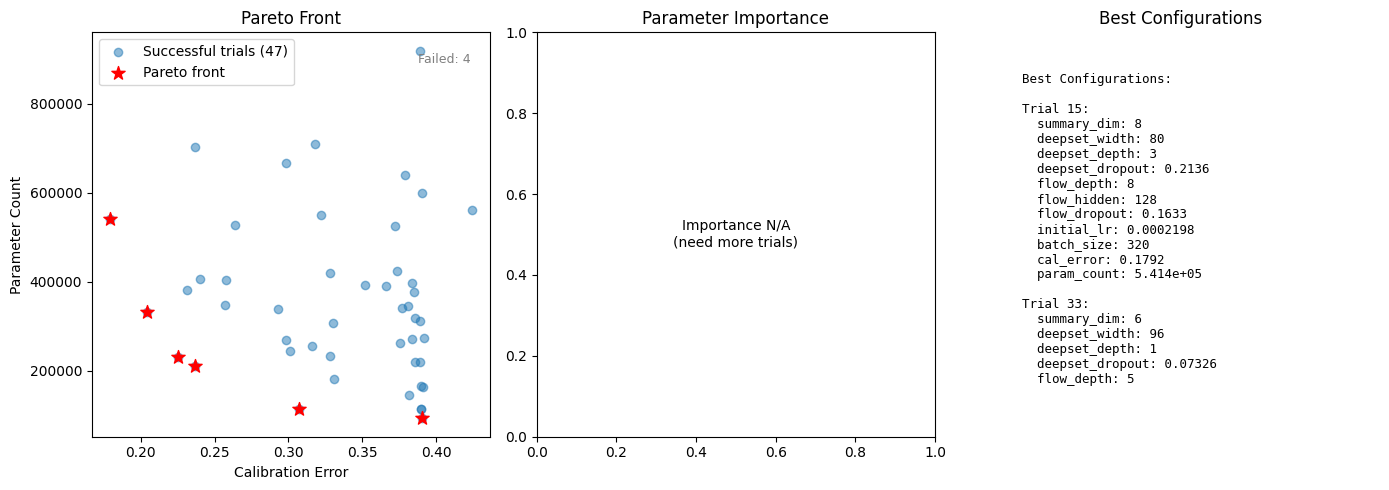

In [8]:
# Plot optimization results
from rctbp_bf_training.core.optimization import plot_optimization_results

fig = plot_optimization_results(study)
plt.show()

## Train Until Threshold (Optional)

Train the best configuration repeatedly until it meets the calibration error threshold.

In [ ]:
# Configuration for threshold-based training
thresholds = QualityThresholds(
    max_cal_error=0.05,
    max_c2st_deviation=0.05,
    max_coverage_error=0.05,
    max_iterations=40,
)

# Extended validation grid for final evaluation
final_conditions = create_validation_grid(extended=True)

print(f"Quality thresholds:")
print(f"  Max calibration error: {thresholds.max_cal_error}")
print(f"  Max C2ST deviation: {thresholds.max_c2st_deviation}")
print(f"  Max coverage error: {thresholds.max_coverage_error}")
print(f"  Max iterations: {thresholds.max_iterations}")
print(f"\nFinal validation grid: {len(final_conditions)} conditions")

In [ ]:
# Create training functions using factory
build_workflow_fn, train_fn, validate_fn = create_ancova_training_functions(
    simulator=simulator,
    adapter=adapter,
    validation_conditions=final_conditions,
    rng=RNG,
)

print("Training functions created via factory for train_until_threshold")

In [ ]:
# Get best hyperparameters from Pareto front and train until threshold
if len(best_configs) > 0:
    selected = best_configs.iloc[0]  # Best calibration
    trial_num = int(selected["trial"])
    trial = [t for t in study.trials if t.number == trial_num][0]
    best_params = trial.params
    
    print(f"Selected trial {trial_num} for threshold training")
    print(f"  Calibration error: {selected['cal_error']:.4f}")
    print(f"  Parameter count: {int(selected['param_count']):,}")
    
    # Train until threshold using the package function
    result = train_until_threshold(
        build_workflow_fn=build_workflow_fn,
        train_fn=train_fn,
        validate_fn=validate_fn,
        hyperparams=best_params,
        thresholds=thresholds,
        verbose=True,
    )
    
    if result["converged"]:
        print(f"\n{'='*60}")
        print("SUCCESS! Quality thresholds met")
        print(f"{'='*60}")
        print(f"Iterations: {result['iterations']}")
        print(f"Final scores:")
        for key, val in result["best_scores"].items():
            print(f"  {key}: {val:.4f}")
        
        best_workflow = result["workflow"]
    else:
        print(f"\nWarning: Did not meet thresholds after {result['iterations']} iterations")
        print(f"Best scores achieved:")
        for key, val in result["best_scores"].items():
            print(f"  {key}: {val:.4f}")
        
        best_workflow = result["workflow"]  # Use best attempt
else:
    print("No trials completed. Run optimization first.")
    best_workflow = None
    result = None

In [ ]:
# Save the best model with metadata
from pathlib import Path
from rctbp_bf_training.models.ancova.model import get_model_metadata, save_model_with_metadata

if best_workflow is not None and result is not None:
    # Get final workflow config from best_params
    final_workflow_config = params_dict_to_workflow_config(best_params)
    
    # Create ANCOVAConfig with optimized settings
    config_optimized = ANCOVAConfig(
        prior=config.prior,
        meta=config.meta,
        workflow=final_workflow_config,
    )
    
    # Save with metadata
    metadata = get_model_metadata(
        config=config_optimized,
        validation_results={
            "converged": result["converged"],
            "iterations": result["iterations"],
            "scores": result["best_scores"],
            "param_count": get_param_count(best_workflow.approximator),
        },
    )
    
    save_path = Path("checkpoints") / "ancova_cont_2arms_optimized"
    saved_path = save_model_with_metadata(best_workflow.approximator, save_path, metadata)
    
    print(f"\n✓ Model saved to: {saved_path}")
    print(f"✓ Metadata saved to: {saved_path.with_suffix('.json')}")
else:
    print("No model to save. Run optimization and threshold training first.")